In [12]:
! pip install transformers datasets

In [13]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import requests
import time

In [18]:
import os
import pandas as pd
from googleapiclient.discovery import build

# Define your API key
api_key = 'Add_your_API_key_here'

# Define the video ID of the YouTube video you want to retrieve comments from
video_id = 'bk-nQ7HF6k4'

# Define the path for the CSV file
csv_path = 'The_Dangers_Of_AI.csv'

# Initialize the YouTube Data API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Function to get video comments
def get_video_comments(youtube, **kwargs):
    comments = []
    results = youtube.commentThreads().list(**kwargs).execute()

    while results:
        for item in results['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            reply_count = item['snippet']['totalReplyCount']
            comments.append({
                'comment_id': item['id'],
                'comment': comment['textDisplay'],
                'author_url': comment['authorChannelUrl'],
                'author_name': comment['authorDisplayName'],
                'reply_count': reply_count,
                'like_count': comment['likeCount'],
                'date': comment['publishedAt'],
                'vidid': comment['videoId'],
                'total_reply_counts': reply_count
            })

        if 'nextPageToken' in results:
            kwargs['pageToken'] = results['nextPageToken']
            results = youtube.commentThreads().list(**kwargs).execute()
        else:
            break

    return comments

# Retrieve comments and save to CSV
comments = get_video_comments(youtube, part='snippet', videoId=video_id, textFormat='plainText')

if comments:
    # Create a DataFrame from the comments
    df = pd.DataFrame(comments)

    # Save to CSV
    df.to_csv(csv_path, index=False)
    print(f'Comments saved to {csv_path}')
else:
    print('No comments found.')


Comments saved to The_Dangers_Of_AI.csv


In [19]:
comments = pd.read_csv('The_Dangers_Of_AI.csv')
comments.shape

(25693, 9)

In [20]:
comments['comment']

0        Mo is back, and this is honestly a conversatio...
1                                                        ❤
2        I was of those 60% I'm not anymore, took care ...
3        Remember when they said big strong violent men...
4                     W.P. has fucked- up this  planet 🌍🌎🌏
                               ...                        
25688                            They truly are delusional
25689                          It is beyond an Emergency 😢
25690    Thank you for this video. A very needed conver...
25691    Disgusting, trying to destroy the traditional ...
25692                                                 Dang
Name: comment, Length: 25693, dtype: object

In [21]:
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

In [22]:
# Remove all the html tags from the comments
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [23]:
# This code is used to precess the text remove unwanted characters and stop words.
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    if isinstance(sen, str):
        sentence = sen.lower()
    else:
    # Handle the case where sen is not a string (e.g., float, None, etc.)
        sentence = str(sen).lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [24]:
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')


comments['processed_comment'] = comments['comment'].apply(preprocess_text)

# Perform sentiment analysis
sia = SentimentIntensityAnalyzer()
comments['sentiment_score'] = comments['processed_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiments
comments['sentiment'] = comments['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Save the processed DataFrame to a CSV file
csv_file_path = 'The_Dangers_Of_AI_with_sentiment.csv'
comments.to_csv(csv_file_path, index=False)

print(f'Data has been saved to {csv_file_path}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bhave\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Data has been saved to The_Dangers_Of_AI_with_sentiment.csv


In [25]:
comments_with_sentiment_df = pd.read_csv('The_Dangers_Of_AI_with_sentiment.csv')
comments_with_sentiment_df.head()

,comment_id,comment,author_url,author_name,reply_count,like_count,date,vidid,total_reply_counts,processed_comment,sentiment_score,sentiment
0,UgxRNRfy58W4Z5XzyNh4AaABAg,"Mo is back, and this is honestly a conversatio...",http://www.youtube.com/@TheDiaryOfACEO,@TheDiaryOfACEO,530,4278,2023-06-01T07:24:06Z,bk-nQ7HF6k4,530,mo back honestly conversation missed please sh...,0.9545,positive
1,UgyFT51aGmDP5cte88B4AaABAg,❤,http://www.youtube.com/@chanelvitale6512,@chanelvitale6512,0,0,2024-04-10T00:01:00Z,bk-nQ7HF6k4,0,,0.0000,neutral
2,UgzL0rPyLJwmDjFcfvV4AaABAg,"I was of those 60% I'm not anymore, took care ...",http://www.youtube.com/@marksutherlandjr.2121,@marksutherlandjr.2121,0,0,2024-04-09T23:39:27Z,bk-nQ7HF6k4,0,anymore took care minor ask thanks scary smart...,0.8176,positive
3,UgyZ2lfTRP0GRNvyV854AaABAg,Remember when they said big strong violent men...,http://www.youtube.com/@AJohnSmith,@AJohnSmith,0,0,2024-04-09T23:37:44Z,bk-nQ7HF6k4,0,remember said big strong violent men problem t...,-0.4404,negative
4,UgztH4qd0sGZ3eLhOYR4AaABAg,W.P. has fucked- up this planet 🌍🌎🌏,http://www.youtube.com/@Anthony-qi4yv,@Anthony-qi4yv,0,0,2024-04-09T22:59:47Z,bk-nQ7HF6k4,0,w fucked planet,-0.6597,negative


In [26]:
# Distribution of Sentiments

sentiment_distribution = comments_with_sentiment_df['sentiment'].value_counts()
print(sentiment_distribution)

sentiment
positive    12606
negative     8598
neutral      4489
Name: count, dtype: int64


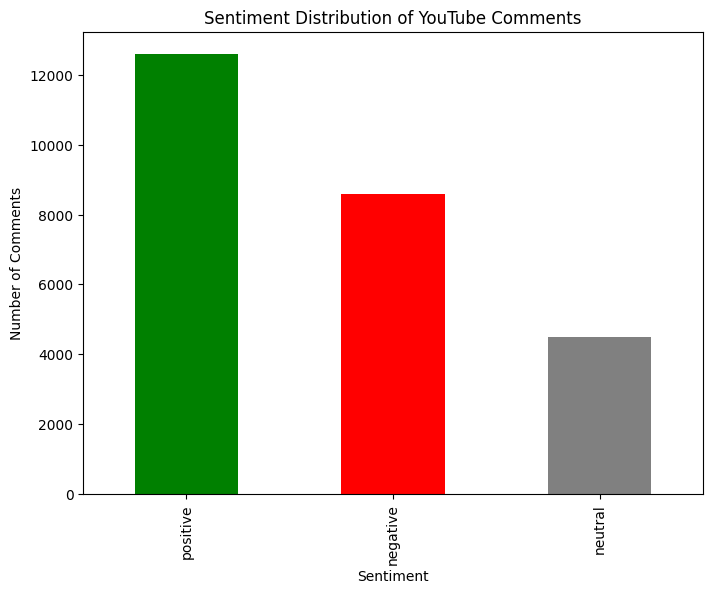

In [27]:
# Sentiment Distribution Bar Chart

import matplotlib.pyplot as plt

sentiment_distribution = comments_with_sentiment_df['sentiment'].value_counts()

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('Sentiment Distribution of YouTube Comments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

In [28]:
#Check Na values
na_count = comments_with_sentiment_df['processed_comment'].isna().sum()

print(f'Number of NaN values in column: {na_count}')

Number of NaN values in column: 23


In [29]:
data = comments_with_sentiment_df[['sentiment', 'processed_comment']]

# Pre-process the data and check for any NaN values -
# as anything other that english language would not have been processed and it would give NaN isntead.
# Remove those comments from the list.
data_cleaned = data.dropna(subset=['processed_comment'])
data_cleaned.shape

(25670, 2)

In [30]:
# Distribution of Sentiments

sentiment_distribution = data_cleaned['sentiment'].value_counts()
print(sentiment_distribution)

sentiment
positive    12606
negative     8598
neutral      4466
Name: count, dtype: int64


In [56]:
data_cleaned.tail()

,sentiment,processed_comment
25688,positive,truly delusional
25689,negative,beyond emergency
25690,positive,thank video needed conversation indeed
25691,negative,disgusting trying destroy traditional family
25692,neutral,dang


<Axes: >

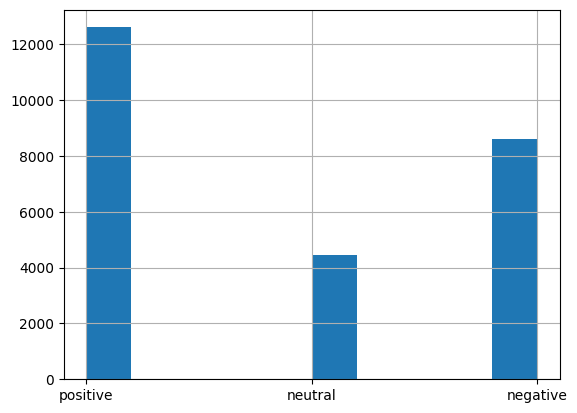

In [57]:
data_cleaned['sentiment'].hist()

In [58]:
target_map = {'positive' : 1, 'negative' : 0, 'neutral' : 2}  # map the labels to integers which is required for neural networks.
data_cleaned['target'] = data_cleaned['sentiment'].map(target_map)

C:\Users\bhave\AppData\Local\Temp\ipykernel_17028\343651625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['target'] = data_cleaned['sentiment'].map(target_map)


In [59]:
df2 = data_cleaned[['processed_comment','target']]
df2.columns =['sentence', 'label'] # saving new csv file with new column names specially important is to change target as label
df2.to_csv('data.csv', index = None) # Converting to csv is important for using hugging face dataset

In [61]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv') # import data to our hugging face datasets. First argument is csv and second argument is path to csv data.

Generating train split: 25670 examples [00:00, 172476.53 examples/s]


In [62]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 25670
    })
})

In [63]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [64]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 17969
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 7701
    })
})

In [65]:
from transformers import AutoTokenizer

In [66]:
# checkpoint = "bert-base-uncased"
checkpoint ="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [67]:
def tokenize_fn(batch): # define function to pass an argument that truncation = True
    return tokenizer(batch['sentence'], truncation=True)

In [68]:
tokenized_datasets = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/17969 [00:00<?, ? examples/s]

Map: 100%|██████████| 7701/7701 [00:00<00:00, 12256.80 examples/s]


In [69]:
from transformers import TrainingArguments, AutoModelForSequenceClassification, Trainer

In [70]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels =3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
! pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [72]:
from torchinfo import summary

In [73]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [74]:
training_args = TrainingArguments(
    output_dir= 'training_dir',
    evaluation_strategy='epoch',  # means if we want to evaluate model on validation set
    save_strategy='epoch',# means save model after every epoch which is not a good idea because you will runout of colab space
    num_train_epochs= 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size= 64
)

In [75]:
def compute_metrics(logits_and_labels): # our own function to compute matrics rather than using hugging face metric becaouse our dataset is custom
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis = -1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'macro')
  return {'accuracy':acc, "f1":f1}



In [76]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

c:\Users\bhave\anaconda3\envs\pytorch_env_assign\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [77]:
trainer.train() # we see that the model is overfit. however we will slect the best checkpoint

 15%|█▍        | 500/3372 [05:38<11:44,  4.08it/s]  

{'loss': 0.5361, 'grad_norm': 5.558994293212891, 'learning_rate': 4.258600237247924e-05, 'epoch': 0.44}


 30%|██▉       | 1000/3372 [11:31<13:00,  3.04it/s] 

{'loss': 0.3525, 'grad_norm': 2.5316922664642334, 'learning_rate': 3.517200474495848e-05, 'epoch': 0.89}


                                                     
 33%|███▎      | 1124/3372 [21:00<11:11,  3.35it/s]

{'eval_loss': 0.26500505208969116, 'eval_accuracy': 0.9040384365666797, 'eval_f1': 0.903570405412124, 'eval_runtime': 495.434, 'eval_samples_per_second': 15.544, 'eval_steps_per_second': 0.244, 'epoch': 1.0}


 44%|████▍     | 1500/3372 [24:50<06:22,  4.89it/s]    

{'loss': 0.2275, 'grad_norm': 2.8406929969787598, 'learning_rate': 2.7758007117437723e-05, 'epoch': 1.33}


 59%|█████▉    | 2000/3372 [30:02<05:15,  4.35it/s]  

{'loss': 0.1966, 'grad_norm': 0.46808797121047974, 'learning_rate': 2.0344009489916967e-05, 'epoch': 1.78}


                                                     
 67%|██████▋   | 2248/3372 [40:55<05:18,  3.53it/s]

{'eval_loss': 0.29717084765434265, 'eval_accuracy': 0.9175431762108817, 'eval_f1': 0.9179858482140232, 'eval_runtime': 489.2614, 'eval_samples_per_second': 15.74, 'eval_steps_per_second': 0.247, 'epoch': 2.0}


 74%|███████▍  | 2501/3372 [43:39<20:00,  1.38s/it]    

{'loss': 0.1473, 'grad_norm': 0.09764071553945541, 'learning_rate': 1.2930011862396206e-05, 'epoch': 2.22}


 89%|████████▉ | 3001/3372 [49:18<01:02,  5.95it/s]

{'loss': 0.0944, 'grad_norm': 0.22095930576324463, 'learning_rate': 5.516014234875446e-06, 'epoch': 2.67}


                                                   
100%|██████████| 3372/3372 [1:01:08<00:00,  4.56it/s]

{'eval_loss': 0.37266477942466736, 'eval_accuracy': 0.923126866640696, 'eval_f1': 0.9233068352571548, 'eval_runtime': 491.8933, 'eval_samples_per_second': 15.656, 'eval_steps_per_second': 0.246, 'epoch': 3.0}


100%|██████████| 3372/3372 [1:01:10<00:00,  1.09s/it]

{'train_runtime': 3670.979, 'train_samples_per_second': 14.685, 'train_steps_per_second': 0.919, 'train_loss': 0.2389924924993006, 'epoch': 3.0}


TrainOutput(global_step=3372, training_loss=0.2389924924993006, metrics={'train_runtime': 3670.979, 'train_samples_per_second': 14.685, 'train_steps_per_second': 0.919, 'train_loss': 0.2389924924993006, 'epoch': 3.0})

In [78]:
from transformers import pipeline

In [79]:
savemodel = pipeline('text-classification', model = 'training_dir/checkpoint-3372', device = 0) # The path of the model is the model save after 2 epochs.

In [80]:
split['test'] # access the test set

Dataset({
    features: ['sentence', 'label'],
    num_rows: 7701
})

In [95]:
test_sentences = split['test']['sentence']
test_sentences = [str(sentence) for sentence in test_sentences]
encoded_test = tokenizer(test_sentences, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_sentences = tokenizer.batch_decode(encoded_test.input_ids, skip_special_tokens=True)



In [96]:
test_pred = savemodel(test_sentences) # run the test set on our saved model to get the test predictions

In [97]:
test_pred

[{'label': 'LABEL_0', 'score': 0.998769223690033},
 {'label': 'LABEL_0', 'score': 0.9984136819839478},
 {'label': 'LABEL_1', 'score': 0.9994439482688904},
 {'label': 'LABEL_1', 'score': 0.9994919300079346},
 {'label': 'LABEL_1', 'score': 0.9979329109191895},
 {'label': 'LABEL_2', 'score': 0.99937504529953},
 {'label': 'LABEL_1', 'score': 0.9993157386779785},
 {'label': 'LABEL_2', 'score': 0.9991463422775269},
 {'label': 'LABEL_2', 'score': 0.9992480874061584},
 {'label': 'LABEL_1', 'score': 0.9982196688652039},
 {'label': 'LABEL_1', 'score': 0.9993769526481628},
 {'label': 'LABEL_0', 'score': 0.9983429908752441},
 {'label': 'LABEL_0', 'score': 0.9986529350280762},
 {'label': 'LABEL_1', 'score': 0.9992734789848328},
 {'label': 'LABEL_1', 'score': 0.999462902545929},
 {'label': 'LABEL_2', 'score': 0.9982594847679138},
 {'label': 'LABEL_0', 'score': 0.9981016516685486},
 {'label': 'LABEL_0', 'score': 0.9988006353378296},
 {'label': 'LABEL_2', 'score': 0.9978175163269043},
 {'label': 'LABE

In [98]:
def get_label(d):  # This function will convert the dictionary above into integers for calculating metrics
  return int(d['label'].split('_')[1])

test_pred =[get_label(d) for d in test_pred]

In [99]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.923126866640696


In [100]:
print("f1:", f1_score(split['test']['label'], test_pred, average = 'macro'))

f1: 0.9233068352571548


In [101]:
def plot_cm(cm):
  classes = ['negative','positive', 'neutral']
  df_cm = pd.DataFrame(cm, index = classes, columns = classes)
  ax = sn.heatmap(df_cm, annot = True, fmt ='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Target')


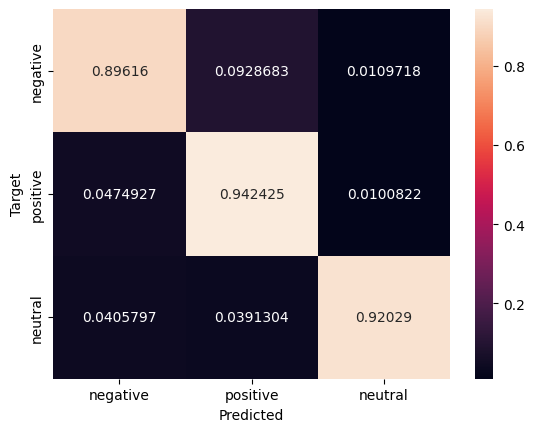

In [102]:
cm = confusion_matrix(split['test']['label'], test_pred, normalize = 'true')
plot_cm(cm)

In [117]:
import random
import textwrap

# Assuming test_pred contains the predictions
predicted_labels = test_pred

# Map label indices to sentiment labels (assuming label mapping is 0 for negative, 1 for neutral, and 2 for positive)
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Get the predicted sentiment for each label
predicted_sentiments = [sentiment_labels[label] for label in predicted_labels]

# Randomly select 5 sample indices
random_indices = random.sample(range(len(test_sentences)), 5)

# Display the random sample sentences and their predicted sentiments
for idx in random_indices:
    wrapped_sentence = textwrap.fill(test_sentences[idx], width=100)
    print("Sentence:", wrapped_sentence)
    print("Predicted Sentiment:", predicted_sentiments[idx])
    print()

Sentence: far ascertain free though agency ai physical component feedback loops massively parallel processing
pain let say longing sensory embodiment risk aversion properties brute organisms without spirit
gibberish feels feels get qualia system sentience imo even qualia bottom hallucinatory necessary
illusion like conviction freedom chose field possibilities
Predicted Sentiment: Neutral

Sentence: understand fillers hmm words reassuring ears talking kind shudder day know even like daddy chill guy
Predicted Sentiment: Neutral

Sentence: thought end humanity could caused yo kid misgendering refrigerator
Predicted Sentiment: Positive

Sentence: hsi voice hurting hed
Predicted Sentiment: Negative

Sentence: bigger guests get bigger bank account gets
Predicted Sentiment: Positive

